# Getting Started with OneMax

This tutorial explains how to implement custom representations
with the following components:

- [Individual](#Representation) as the
  _binary string_ representation.

- [Variator](#Variator) as the _random bit mutator_
  which modifies each bit of the binary string with a fixed probability.

- [Evaluator](#Evaluator) as the _bit distance
  evaluator_ which sums all bits in a bit string.

- [Put Everything Together](#Put-Everything-Together) runs
  an evolutionary algorithm using the operators defined above,
  in addition to a stock selector.

Typically, these components are required to solve an optimisation
problem: (a) the individual represents solutions, (b) the variator
must know the representation to change it, and (c) the evaluator
assesses how the individual solves the problem.

<img src='media\ec-locate-onemax.svg' style='width: 30em'></img>

## Individual

All custom representations must derive `evokit.core.population.Individual`.

At minimum, the implementation must do the following:
    
1. Initialise `.genome` to store the representation.

3. Override `.copy(..)` to return an independent copy.

The implementation must decide how to initialise new individuals.
In this example, the class `BitString` implements a factory
method `BitString.random(..)`, which creates a uniformly
random bit string of the given length.

In [1]:
from __future__ import annotations
from typing import Self
from typing import override

In [2]:
from random import getrandbits
from evokit.core import Individual

class BitString(Individual[list[int]]):
    @override
    def __init__(self, value: list[int]) -> None:
        """Required.

        Initialise the genome.
        """
        self.genome: list[int] = value

    @override
    def copy(self: Self) -> Self:
        """Required.
        
        Ensure that operations performed on
        a copy do not affect to the original individual.
        """
        return type(self)(self.genome.copy())

    @staticmethod
    def random(len: int) -> BitString:
        """Not required.
        
        Initialise a random individual.
        """
        return BitString(
            (len * [0] +
                [int(digit)
                 for digit in bin(getrandbits(len))[2:]])[-len:]
        )

    @override
    def __str__(self: Self) -> str:
        """Not required.
        
        Return a text representation of the individual.
        """
        return str(self.genome)

## Variator

All custom variators must derive `evokit.core.variator.Variator`.

At minimum, the implementation must do the following:
    
1. Initialise `.arity` to specify how many parents are passed to `.vary`.

2. Override `.vary(..)` method to specify how to create new individuals from existing ones.
   Be sure to call `.copy` before making changes to an existing individual.

In this example, `.vary` receives an 1-tuple because `.arity=2`.

In [ ]:
from random import random
from typing import Sequence

from evokit.core import Variator

class RandomBitMutator(Variator[BitString]):
    @override
    def __init__(self, mutation_rate: float):
        self.arity = 1

        # Not required. Raise an error if the mutation rate is too big or small.
        if (mutation_rate < 0 or mutation_rate > 1):
            raise ValueError(f"Mutation rate must be within {0} and {1}."
                             f"Got: {mutation_rate}")
        
        # The mutation rates is a parameter of the variator.
        self.mutation_rate = mutation_rate
    
    @override
    def vary(self, parents: Sequence[BitString]) -> tuple[BitString,
                                                          BitString]:
        """Required.

        Produce new individuals from existing ones.
        
        Because `.arity=1` in the initialiser, `parents` will be a 1-tuple at runtime.
        """
        offspring = parents[0].copy()

        for i in range(0, len(offspring.genome)):
            if (random() < self.mutation_rate):
                offspring.genome[i] = 1 if offspring.genome[i] == 0 else 1

        return (offspring, parents[0].copy())

# Evaluator

All custom evaluators must derive `evokit.core.evaluator.Evaluator`.

At minimum, the implementation must override the `.evaluate(..)` method. This method should take one individual of the correct type, then return its fitness(es) in a tuple.

The `.evaluate_population(..)` method, which is not covered here, applies `.evaluate(..)` to each 

In this example, `.evaluate(..)` returns a 1-tuple because it uses only one measure of fitness. The method sums all bits in the `.genome` of a `BitString`.

In [4]:
from evokit.core import Evaluator
from typing import override

class BitDistanceEvaluator(Evaluator[BitString]):
    @override
    def evaluate(self, individual: BitString) -> tuple[float]:
        return (sum(individual.genome),)

## Put Everything Together

Construct an evolutionary algorithm with components defined
above, in addition to a stock selector
`evolvables.selectors.TruncationSelector`
(see the [Selector Tutorial](./selector.ipynb) for how to construct it)
and a stock algorithm `evolvables.algorithms.SimpleLinearAlgorithm`
(see the [Algorithm Tutorial](./algorithm.ipynb) for
how to make your own). Selectors are algorithms are independent
to problem and solution representations.

This example also use an elitist (hall-of-fame) truncation selector.
This is done by wrapping the selector with `Elitist` (see the
[Interceptor Tutorial](./interceptor.ipynb) for more information).

Each step of the algorithm includes the following operations:

1. `evaluate` the `population`
2. `select` from `population`
    * then, `update` `population` with the result
3. `vary` `population`
    * then, `update` the `population` with the result


In [5]:
from evokit.evolvables.selectors import Elitist, TruncationSelector
from evokit.evolvables.algorithms import SimpleLinearAlgorithm

### Initialise Population

The algorithm should begin with a pool of candidate solutions.
Create a number of `BitString` instances, then store them in
a `Population`. This is the initial population.

In [6]:
from evokit.core import Population

BINSTRING_LENGTH: int = 1000
POPULATION_SIZE: int = 20
GENERATION_COUNT: int = 100
init_pop = Population[BitString]()

for i in range(0, POPULATION_SIZE):
    init_pop.append(BitString.random(BINSTRING_LENGTH))

### Define the Algorithm

Initialise operators, then initialise the algorithm with these operators.
Everything has already been defined or imported, so using them is easy.

In [7]:
ctrl: SimpleLinearAlgorithm[BitString] =\
        SimpleLinearAlgorithm[BitString](
    population=init_pop,
    variator=RandomBitMutator(0.1),
    selector=Elitist(TruncationSelector[BitString](POPULATION_SIZE)),
    evaluator = BitDistanceEvaluator()
)

### Run the Algorithm

Run the algorithm, then record the best individual of
each generation. Be sure call `copy`, so that the retained individual
is not affected by operations on the original.

In [8]:
bests: list[BitString] = []

for _ in range(GENERATION_COUNT):
    ctrl.step()
    bests.append(ctrl.population.best().copy())

### Analyse Results

As `bests` records highest-fitness individuals of each generation,
its last item should have higher fitness than the first.
Observe the difference:

In [9]:
print(f"Best individual of the first generation is {bests[0]}")
print(f"    with fitness {sum(bests[0].genome)}")
print(f"Best individual of the last generation is {bests[-1]}")
print(f"    with fitness {sum(bests[-1].genome)}")

Best individual of the first generation is [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,

Plot the training curve, note that the increase in
fitness slows down near convergence.

For EvoKit's specialised
data collection and reporting module, see the
[Watcher Tutorial](./watcher.ipynb).

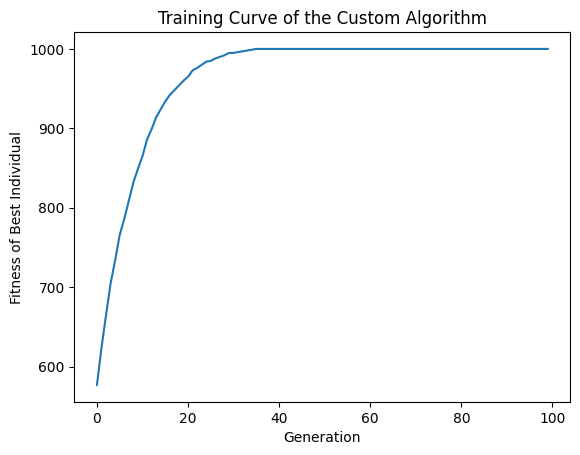

In [10]:
# type: ignore[reportUnknownMemberType]
from matplotlib import pyplot as plt

plt.title('Training Curve of the Custom Algorithm') 
plt.xlabel('Generation')
plt.ylabel('Fitness of Best Individual')
plt.plot([i for i in range(len(bests))], [sum(x.genome) for x in bests])
plt.show()